In [1]:
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.distributions import Normal

pygame 2.5.2 (SDL 2.28.3, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\setuptools\_distutils\version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\Lo

In [2]:
def init_layer_uniform(layer: nn.Linear, init_w: float = 3e-3) -> nn.Linear:
    """Init uniform parameters on the single layer."""
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)

    return layer

class Actor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int, 
        log_std_min: int = -20,
        log_std_max: int = 0,
    ):
        """Initialize."""
        super(Actor, self).__init__()

        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.hidden = nn.Linear(in_dim, 32)

        self.mu_layer = nn.Linear(32, out_dim)
        self.mu_layer = init_layer_uniform(self.mu_layer)

        self.log_std_layer = nn.Linear(32, out_dim)
        self.log_std_layer = init_layer_uniform(self.log_std_layer)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden(state))
        
        mu = torch.tanh(self.mu_layer(x))
        log_std = torch.tanh(self.log_std_layer(x))
        log_std = self.log_std_min + 0.5 * (
            self.log_std_max - self.log_std_min
        ) * (log_std + 1)
        std = torch.exp(log_std)

        dist = Normal(mu, std)
        action = dist.sample()

        return action, dist


class Critic(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(Critic, self).__init__()

        self.hidden = nn.Linear(in_dim, 64)
        self.out = nn.Linear(64, 1)
        self.out = init_layer_uniform(self.out)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu(self.hidden(state))
        value = self.out(x)

        return value

In [3]:
def compute_gae(
    next_value: list, 
    rewards: list, 
    masks: list, 
    values: list, 
    gamma: float, 
    tau: float
) -> List:
    """Compute gae."""
    values = values + [next_value]
    gae = 0
    returns: Deque[float] = deque()

    for step in reversed(range(len(rewards))):
        delta = (
            rewards[step]
            + gamma * values[step + 1] * masks[step]
            - values[step]
        )
        gae = delta + gamma * tau * masks[step] * gae
        returns.appendleft(gae + values[step])

    return list(returns)

In [4]:
def ppo_iter(
    epoch: int,
    mini_batch_size: int,
    states: torch.Tensor,
    actions: torch.Tensor,
    values: torch.Tensor,
    log_probs: torch.Tensor,
    returns: torch.Tensor,
    advantages: torch.Tensor,
):
    """Yield mini-batches."""
    batch_size = states.size(0)
    for _ in range(epoch):
        for _ in range(batch_size // mini_batch_size):
            rand_ids = np.random.choice(batch_size, mini_batch_size)

            yield states[rand_ids, :], actions[rand_ids], values[
                rand_ids
            ], log_probs[rand_ids], returns[rand_ids], advantages[rand_ids]

In [5]:
class PPOAgent:
    """PPO Agent.
    Attributes:
        env (gym.Env): Gym env for training
        gamma (float): discount factor
        tau (float): lambda of generalized advantage estimation (GAE)
        batch_size (int): batch size for sampling
        epsilon (float): amount of clipping surrogate objective
        epoch (int): the number of update
        rollout_len (int): the number of rollout
        entropy_weight (float): rate of weighting entropy into the loss function
        actor (nn.Module): target actor model to select actions
        critic (nn.Module): critic model to predict state values
        transition (list): temporory storage for the recent transition
        device (torch.device): cpu / gpu
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)        
    """

    def __init__(
        self,
        env: gym.Env,
        batch_size: int,
        gamma: float,
        tau: float,
        epsilon: float,
        epoch: int,
        rollout_len: int,
        entropy_weight: float,
    ):
        """Initialize."""
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch = epoch
        self.rollout_len = rollout_len
        self.entropy_weight = entropy_weight

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.critic = Critic(obs_dim).to(self.device)

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.005)

        # memory for training
        self.states: List[torch.Tensor] = []
        self.actions: List[torch.Tensor] = []
        self.rewards: List[torch.Tensor] = []
        self.values: List[torch.Tensor] = []
        self.masks: List[torch.Tensor] = []
        self.log_probs: List[torch.Tensor] = []

        # total steps count
        self.total_step = 1

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        state = torch.FloatTensor(state).to(self.device)
        action, dist = self.actor(state)
        selected_action = dist.mean if self.is_test else action
        if not self.is_test:
            value = self.critic(state)
            self.states.append(state)
            self.actions.append(selected_action)
            self.values.append(value)
            self.log_probs.append(dist.log_prob(selected_action))

        return selected_action.cpu().detach().numpy()

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = truncated or terminated
        next_state = np.reshape(next_state, (1, -1)).astype(np.float64)
        reward = np.reshape(reward, (1, -1)).astype(np.float64)
        done = np.reshape(done, (1, -1))

        if not self.is_test:
            self.rewards.append(torch.FloatTensor(reward).to(self.device))
            self.masks.append(torch.FloatTensor(1 - done).to(self.device))

        return next_state, reward, done

    def update_model(
        self, next_state: np.ndarray
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines

        next_state = torch.FloatTensor(next_state).to(device)
        next_value = self.critic(next_state)

        returns = compute_gae(
            next_value,
            self.rewards,
            self.masks,
            self.values,
            self.gamma,
            self.tau,
        )

        states = torch.cat(self.states).view(-1, 2)
        actions = torch.cat(self.actions)
        returns = torch.cat(returns).detach()
        values = torch.cat(self.values).detach()
        log_probs = torch.cat(self.log_probs).detach()
        advantages = returns - values

        actor_losses, critic_losses = [], []



        for state, action, old_value, old_log_prob, return_, adv in ppo_iter(
            epoch=self.epoch,
            mini_batch_size=self.batch_size,
            states=states,
            actions=actions,
            values=values,
            log_probs=log_probs,
            returns=returns,
            advantages=advantages,
        ):
            # calculate ratios
            _, dist = self.actor(state)
            log_prob = dist.log_prob(action)
            ratio = (log_prob - old_log_prob).exp()

            # actor_loss
            surr_loss = ratio * adv
            clipped_surr_loss = (
                torch.clamp(ratio, 1.0 - self.epsilon, 1.0 + self.epsilon) * adv
            )

            # entropy
            entropy = dist.entropy().mean()

            actor_loss = (
                -torch.min(surr_loss, clipped_surr_loss).mean()
                - entropy * self.entropy_weight
            )

            # critic_loss
            value = self.critic(state)
            #clipped_value = old_value + (value - old_value).clamp(-0.5, 0.5)
            critic_loss = (return_ - value).pow(2).mean()
        
            # train critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward(retain_graph=True)
            self.critic_optimizer.step()

            # train actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            actor_losses.append(actor_loss.item())
            critic_losses.append(critic_loss.item())

        self.states, self.actions, self.rewards = [], [], []
        self.values, self.masks, self.log_probs = [], [], []

        actor_loss = sum(actor_losses) / len(actor_losses)
        critic_loss = sum(critic_losses) / len(critic_losses)

        return actor_loss, critic_loss

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state, _ = self.env.reset()

        state = np.expand_dims(state, axis=0)


        actor_losses, critic_losses = [], []
        scores = []
        score = 0
        

        while self.total_step <= num_frames + 1:
            for _ in range(self.rollout_len):
                self.total_step += 1
                action = self.select_action(state)
                next_state, reward, done = self.step(action[0])

                state = next_state
                score += reward[0][0]

                # if episode ends
                if done[0][0]: #or step > 999:
                    state, _ = env.reset()
                    state = np.expand_dims(state, axis=0)
                    scores.append(score)
                    score = 0
                    self._plot(
                        self.total_step, scores, actor_losses, critic_losses
                    )


            actor_loss, critic_loss = self.update_model(next_state)
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)

        # termination
        self.env.close()
        return scores

    def test(self):
        """Test the agent."""
        self.is_test = True

        state, _ = self.env.reset()
        done = False
        score = 0

        frames = []
        while not done:
            frames.append(self.env.render(mode="rgb_array"))
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        return frames

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
    ):
        """Plot the training progresses."""

        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

In [6]:
env_id = "MountainCarContinuous-v0"
env = gym.make(env_id)

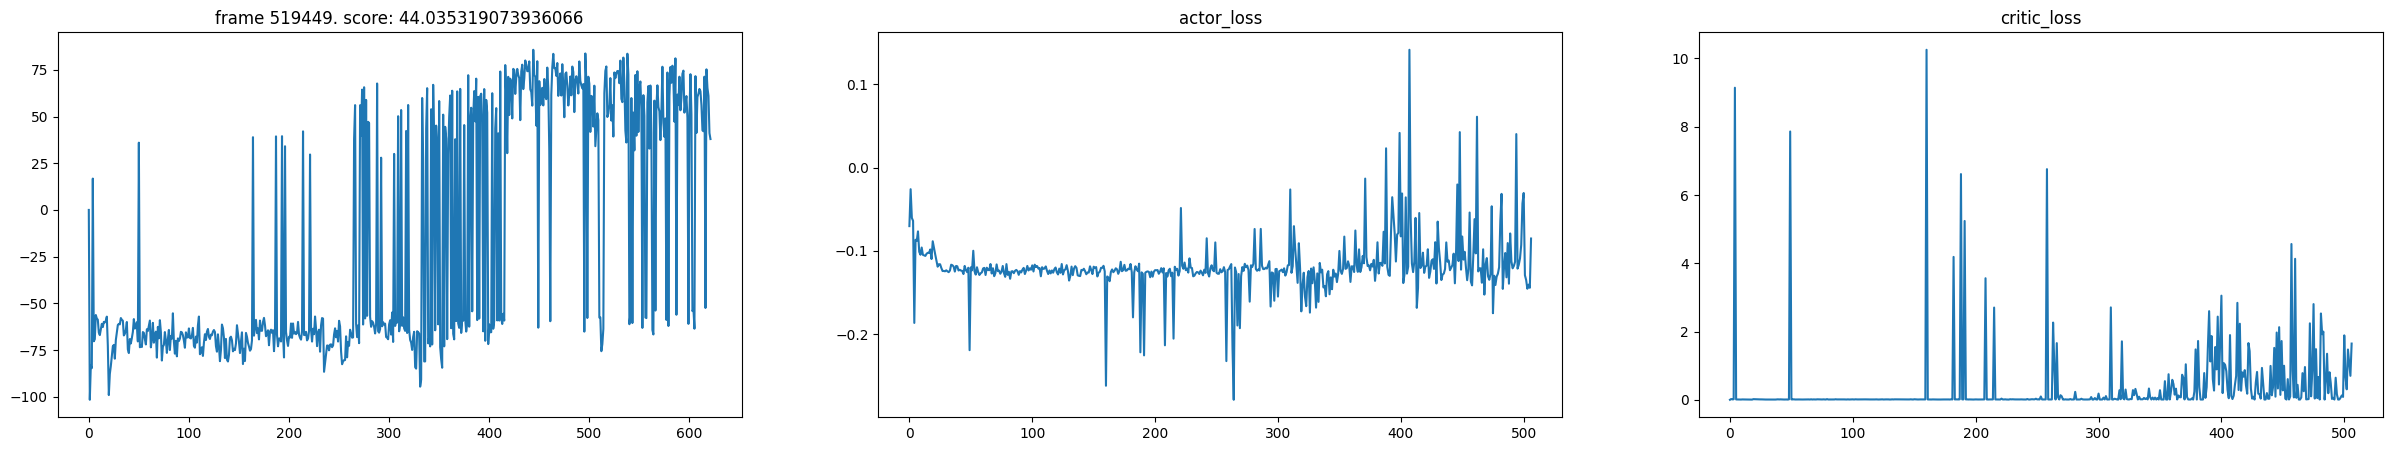

In [21]:
num_frames = 520000
reward_list = []
for i in range(5):
    agent = PPOAgent(
    env,
    gamma = 0.9,
    tau = 0.1,
    batch_size = 64,
    epsilon = 0.125,
    epoch = 64,
    rollout_len = 1024,
    entropy_weight = 0.1
    )
    reward = agent.train(num_frames)
    reward_list.append(reward)

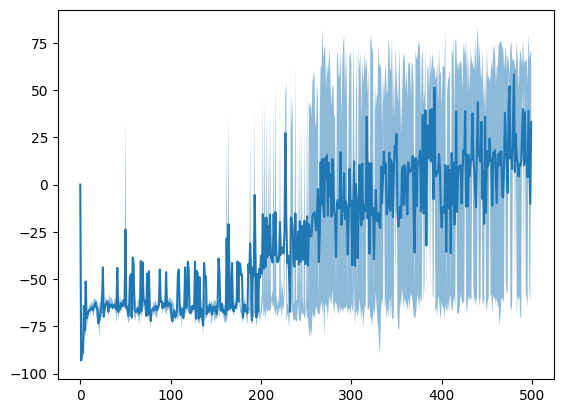

In [24]:
reward_list_trunc = [row[:500] for row in reward_list]
mean = np.mean(reward_list_trunc, axis = 0)
plt.plot(range(500), mean[:500])
par_1_75, par_1_25 = np.percentile(reward_list_trunc, [75, 25], axis = 0)
plt.fill_between(range(500), par_1_25[:500],  par_1_75[:500], alpha = 0.5)

In [25]:
import pickle
dataStore = {}

dataStore['PPO_GAE'] = reward_list_trunc
    
with open('./' + 'Results_PPO+GAE_MCC' + '.pkl', 'wb') as fp:
        pickle.dump(dataStore, fp)
        print('dictionary saved successfully to file')

dictionary saved successfully to file
